# Training the neural network for indoor localization
## Training the proposed deep net architecture and evaluating its preformance
The notebook contains code used for training the proposed NN and evaluating the various performance metrics. The model estimates the x, y, and z coordinates from the Received Signal Strength(RSS) perceived by cellphones from 992 WiFi routers in the building. This model was proposed after hundreds of models were tested on all possible metrics. The notebooks were run on the kaggle platform for training purposes. **Since the initial weights of the deep neural net are random, the accuracies might not match with the accuracies
given in the publication.**

## Description of proposed NN
In the publication, the mlpregressor model in scikit-learn, a machine learning library in python, was used. A mlpregressor model has outputs which are continuous values and uses the mean squared error as the loss function. The mlpregressor supports various parameters for learning whose values are tuned with the kind and type of dataset for optimal performance. The best performing model for the fingerprinting dataset, after hypertuning, has 6 hidden layers with (400,200,200,100,100,50) number of nodes in each layer. The non-linear activation function and optimizer used for training was ReLU and ’adam’ respectively, with the number of iterations/epochs being 250.

### Table of Contents
* [1. Importing all modules](#1)
* [2. Loading and Preprocessing train and test data](#2)
* [3. Removing cellphone models with very few data points from training set](#3)
* [4. Training the best model](#4)
* [5. Calculating the floor prediction accuracy](#5)
* [6. Training the best model](#6)
* [7. Performance Graphs: Separate Model for three most used devices](#7)
* [8. Performance Graphs: Comparison between Separate Model and Overall Model](#8)
* [9. Cumulative Distribution Functions of 3D localization error: net distribution and each device distribution](#9)

<a id="1"></a>
### 1. Importing all modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import genfromtxt
import matplotlib as mpl
from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

<a id="2"></a>
### 2. Loading and preprocessing train and test data
Training data was loaded and split randomly by the cell below. The matrices were then pickeled, and loaded into other scripts for testing to maintain homogeneity between all scripts. 


In [2]:
train_data_org=pd.read_csv("../input/Training_rss_21Aug17.csv",header=None)
train_target_org=pd.read_csv("../input/Training_coordinates_21Aug17.csv",header=None)
test_data_org=pd.read_csv("../input/Test_rss_21Aug17.csv",header=None)
test_target_org=pd.read_csv("../input/Test_coordinates_21Aug17.csv",header=None)
train_device = pd.read_csv("../input/Training_device_21Aug17.csv")
test_device = pd.read_csv("../input/Test_device_21Aug17.csv")

train_device.loc[-1] = [train_device.columns.values[0]]  # adding a row
train_device.index = train_device.index + 1  # shifting index
train_device.sort_index(inplace=True) 
train_device.columns = ['995']

test_device.loc[-1] = [test_device.columns.values[0]]  # adding a row
test_device.index = test_device.index + 1  # shifting index
test_device.sort_index(inplace=True) 
test_device.columns = ['995']
train_data_org.iloc[:10]

# replacing 100 with 0 as this gave better results for unheard Access Points
test_data = test_data_org.replace({100:0})
train_data = train_data_org.replace({100:0})

data = test_data.append(train_data,  ignore_index=True)

target = test_target_org.append(train_target_org,  ignore_index=True)

device = train_device.append(test_device,  ignore_index=True)

target.columns = ['992','993','994']
frames = [data, target, device]
big_data = pd.concat(frames,axis=1)

from sklearn.model_selection import train_test_split
train, test= train_test_split(big_data, test_size=0.2)
#test, val = train_test_split(blah, test_size=0.5)

#splitting for target
#train_data =  np.exp(train.iloc[:,0:992])
train_data =  (train.iloc[:,0:992])
train_target_x = train.iloc[:,992]
train_target_y = train.iloc[:,993]
train_target_z = train.iloc[:,994]
print(type(train_data))

test_data =  (test.iloc[:,0:992])
test_target_x = test.iloc[:,992]
test_target_y = test.iloc[:,993]
test_target_z = test.iloc[:,994]

device.to_pickle('device')
big_data.to_pickle('big_data')
train_data.to_pickle('train_index')
test_data.to_pickle('test_index')
train_target_x.to_pickle('train_x')
train_target_y.to_pickle('train_y')
train_target_z.to_pickle('train_z')
test_target_x.to_pickle('test_x')
test_target_y.to_pickle('test_y')
test_target_z.to_pickle('test_z')

**Loading the pickeled files and replacing the hundreds with zeros**

In [3]:
train_data_org = pd.read_pickle('../input/creation-main/train_index')
device_org=pd.read_pickle('../input/creation-main/device')
big_data_org = pd.read_pickle('../input/creation-main/big_data')
test_data_org = pd.read_pickle('../input/creation-main/test_index')

train_target_x_org = pd.read_pickle('../input/creation-main/train_x')
train_target_y_org = pd.read_pickle('../input/creation-main/train_y')
train_target_z_org = pd.read_pickle('../input/creation-main/train_z')
test_target_x_org = pd.read_pickle('../input/creation-main/test_x')
test_target_y_org = pd.read_pickle('../input/creation-main/test_y')
test_target_z_org = pd.read_pickle('../input/creation-main/test_z')

test_data_noprs = test_data_org.replace({0:100})
train_data_noprs = train_data_org.replace({0:100})


train_target=train_target_x_org.to_frame().join(train_target_y_org)
train_target=train_target.join(train_target_z_org)


test_target=test_target_x_org.to_frame().join(test_target_y_org)
test_target=test_target.join(test_target_z_org)

train_data_org.iloc[:10]
print(train_data_noprs.shape)


(3718, 992)


**Normalizing the dataset**


Normalizing the RSS values of the training set, and using the derived mean and std_dev to transform the test data.


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
print(scaler.fit(train_data_org))

# Now apply the transformations to the data:
train = scaler.transform(train_data_org)
train_data_scale = pd.DataFrame(train, index=train_data_org.index, columns=train_data_org.columns)

# Now apply the transformations to the data:
test = scaler.transform(test_data_org)
test_data_scale = pd.DataFrame(test, index=test_data_org.index, columns=test_data_org.columns)

StandardScaler(copy=True, with_mean=True, with_std=True)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


<a id="3"></a>
### 3. Removing cellphone models with very few data points from training set
These data points were added to the test set instead to create the notion of encountering new device models during testing.


In [5]:
#big_data refers to teh dataframe having a column stating the device models too

d = big_data_org['995'].value_counts()
print(test_data_scale.shape)
print(test_target.shape)
print(train_data_scale.shape)
print(train_target.shape)
for k in range(13,21):
    test = np.zeros((0,992))
    test3d=np.zeros((0,3))
    train=train_data_scale.copy(deep=True)
    train3d=train_target.copy(deep=True)
    i=0
    l=train_data_scale.shape[0]
    print(train3d.shape)
    for c in range(0,l):
        if big_data_org.iloc[train.index[i]]['995']==d.index[k]:
            #t=pd.DataFrame(data=np.transpose(train.loc[train.index[i],:].values.reshape(1,992)), index=train.index[i], columns=range(0,992)) 
            test_data_scale=test_data_scale.append(train.loc[train.index[i],:])
            train = train.drop([train.index[i]], axis=0)
            #t=pd.DataFrame(data=np.transpose(train3d.loc[train3d.index[i],:].values.reshape(1,3)), index=train.index[i], columns=['992','993','994']) 
            test_target=test_target.append(train3d.loc[train3d.index[i],:])
            train3d = train3d.drop([train3d.index[i]], axis=0)
            l=l-1
            i=i-1
        if i==(l-2):
            break
        i=i+1
    train_data_scale=train.copy(deep=True)
    train_target=train3d.copy(deep=True)
print(test_data_scale.shape)
print(test_target.shape)
print(train_data_scale.shape)
print(train_target.shape)

(930, 992)
(930, 3)
(3718, 992)
(3718, 3)
(3718, 3)
(3642, 3)
(3579, 3)
(3573, 3)
(3571, 3)
(3569, 3)
(3567, 3)
(3566, 3)
(1083, 992)
(1083, 3)
(3565, 992)
(3565, 3)


<a id="4"></a>
### 4. Training the best model

Ten models were trained out of the which the best performing model in term sof mean 3D error was chosen. **All the values beyond this cell: accuracies, errors and other performance metrics, might not match with the ones given in the publication. Each run of the notebook gives different metrics and graphs**. Kindly send me an email if you need the weights of the neural net used in the publication.

In [6]:
minn=100
for i in range(0,10):
 
    mlp = MLPRegressor(hidden_layer_sizes=(400,200,200,100,100,50), max_iter=250)     
    mlp.fit(train_data_scale,train_target)
    mean3d = np.sum(pow((np.sum(pow(abs(test_target-mlp.predict(test_data_scale)),2),axis=1)),0.5))/test_data_scale.shape[0]
    if minn > mean3d:
        minn = mean3d
        model = mlp
mlp=model
overallmodel=model
tr_acc= mlp.score(train_data_scale, train_target)*100  
mean3d = np.sum(pow((np.sum(pow(abs(test_target-mlp.predict(test_data_scale)),2),axis=1)),0.5))/test_data_scale.shape[0]
# meand 2d error is calculated using just the x and y coordinates
mean2d = np.sum(pow((np.sum(pow(abs(test_target-mlp.predict(test_data_scale)).drop(['994'],axis=1),2),axis=1)),0.5))/test_data_scale.shape[0]
max_err = np.max(pow((np.sum(pow(abs(test_target-mlp.predict(test_data_scale)),2),axis=1)),0.5))
z = np.sum(abs(test_target-mlp.predict(test_data_scale)))/test_data_scale.shape[0]
print("train acc",tr_acc)
print('mean3d',mean3d)
print('mean2d',mean2d)
print("max",max_err)

train acc 99.46029176534168
mean3d 7.117461947806395
mean2d 6.984951011798926
max 58.27178446730483


<a id="5"></a>
### 5. Calculating the floor prediction accuracy

Using the visualization of the dataset, we estimated the floor heights and classified each of the z-coordinates into one of the five floors in the building.


In [7]:
#for floor prediction accuracy
def floorprediction(test_target,k):
    k=np.delete(k,0,1)
    k=np.delete(k,0,1)
    k1=np.copy(k)
    for i in range(0,len(k)):
        if k[i]<=1.35:
            k[i]=0.0
        if k[i]>1.35 and k[i]<=5.05:
            k[i]=3.7
        if k[i]>5.05 and k[i]<=8.75:
            k[i]=7.4
        if k[i]>8.75 and k[i]<=12.45:
            k[i]=11.1
        if k[i]>12.45 and k[i]<=16.15:
            k[i]=14.8
    m=np.delete(test_target,0,1)
    m=np.delete(m,0,1)
    l=abs(k-m)
    c=0
    for i in range(0,len(l)):
        if l[i]==3.7:
            if abs(k1[i]-m[i])<=2:
                c=c+1          
    import collections
    c=(np.count_nonzero(l==0)+c)/len(k)
    return c     


<a id="6"></a>
### 6. Training separate models for three most used devices for comparison

This serves as a comparison between a model trained for all devices vs a model trained separately for each device. State of the art methods and literature suggest training separate models for device with significant number of data points in the database. 

However, this methodology is not practical and neither is problem complexity manageable by small devices which typically use such localization services. 

To further explore the statement, separate models were trained for three most used devices, The original train and test set split remained the same for unbiased comparison. The training set for each device being those device instances in the original training set and the test set being those device instances from the test set. 



In [8]:
d = big_data_org['995'].value_counts()

# big_data has columns having device model names

# the following metrics are derived for three top most used devices 
# thus the array lengths are 3

mean3d=[0.0,0.0,0.0]
mean2d=[0.0,0.0,0.0]
floorpred=[0.0,0.0,0.0]
mean3doverall=[0.0,0.0,0.0]
mean2doverall=[0.0,0.0,0.0]
floorpredoverall=[0.0,0.0,0.0]
print(d.index[0])
for k in range(0,3):
    test = np.zeros((0,992))
    test3d=np.zeros((0,3))
    train=train_data_scale.copy(deep=True)
    train1=train_data_scale.copy(deep=True)
    train3d=train_target.copy(deep=True)
    train3d1=train_target.copy(deep=True)
    l=train.shape[0]
    
    # The original train and test set split remained the same for unbiased comparison
    # we extract all data points with the device model and rescale and reshape it
    
    for i in range(0,test_data_scale.shape[0]-1):
        if big_data_org.iloc[test_data_scale.index[i]]['995']==d.index[k]:
            test=np.append(test,np.transpose(test_data_scale.loc[test_data_scale.index[i],:].values.reshape(992,1)),axis=0)
            test3d=np.append(test3d,np.transpose(test_target.loc[test_target.index[i],:].values.reshape(3,1)),axis=0)
            i=i-1
    i=0
    for c in range(0,l):
        if big_data_org.iloc[train.index[i]]['995']!=d.index[k]:
            train = train.drop([train.index[i]], axis=0)
            train3d = train3d.drop([train3d.index[i]], axis=0)
            
            l=l-1
            i=i-1
            if i==(l-2):
                break
        i=i+1
    
    from sklearn.neural_network import MLPRegressor
    minn=100
    
    # again we train 10 models and choose the best one
    for i in range(0,10):
        mlp = MLPRegressor(hidden_layer_sizes=(400,200,200,100,100,50), max_iter=250)   
        mlp.fit(train,train3d)
        mean3d[k] = np.sum(pow((np.sum(pow(abs(test3d-mlp.predict(test)),2),axis=1)),0.5))/test.shape[0]
        if minn>mean3d[k]:
            model =mlp
            minn=mean3d[k]
    mlp=model
    mean3d[k] = np.sum(pow((np.sum(pow(abs(test3d-mlp.predict(test)),2),axis=1)),0.5))/test.shape[0]
    mean2d[k] = np.sum(pow((np.sum(pow(np.delete(abs(test3d-mlp.predict(test)),2,1),2),axis=1)),0.5))/test.shape[0]
    floorpred[k] = floorprediction(test3d, mlp.predict(test))*100
    
    mlp=overallmodel
    mean3doverall[k] = np.sum(pow((np.sum(pow(abs(test3d-mlp.predict(test)),2),axis=1)),0.5))/test.shape[0]
    mean2doverall[k] = np.sum(pow((np.sum(pow(np.delete(abs(test3d-mlp.predict(test)),2,1),2),axis=1)),0.5))/test.shape[0]
    floorpredoverall[k] = floorprediction(test3d, mlp.predict(test))*100
    
    
            

Letv x600


/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<a id="7"></a>
### 7. Performance Graphs: Separate Model for three most used devices

The following graph shows how each model for the top three devices perform.

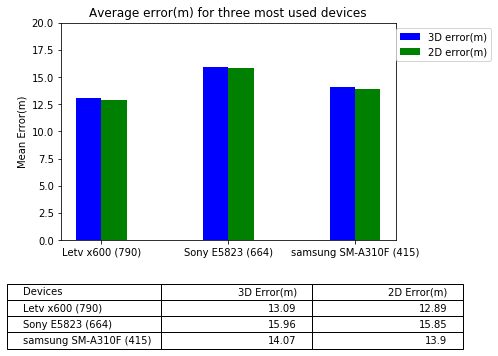

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar([-0.1,0.9,1.9], mean3d,width=0.2,color='b',label='3D error(m)',align='center')
ax.bar([0.1,1.1,2.1],mean2d, width=0.2,color='g',label='2D error(m)',align='center')
ax.set_title('Average error(m) for three most used devices');

ax.set_ylabel('Mean Error(m)');
plt.xticks(range(0,3),[d.index[0]+' ('+str(d[0])+')',d.index[1]+' ('+str(d[1])+')',d.index[2]+' ('+str(d[2])+')'])
row_labels=['Devices',d.index[0]+' ('+str(d[0])+')',d.index[1]+' ('+str(d[1])+')',d.index[2]+' ('+str(d[2])+')']
table_vals=[['3D Error(m)','2D Error(m)'],
            [float('{0:.2f}'.format(mean3d[0])),float('{0:.2f}'.format(mean2d[0]))],
            [float('{0:.2f}'.format(mean3d[1])),float('{0:.2f}'.format(mean2d[1]))],
            [float('{0:.2f}'.format(mean3d[2])),float('{0:.2f}'.format(mean2d[2]))]]
the_table = plt.table(cellText=table_vals,
                  rowLabels=row_labels,colWidths=[0.2]*2,
                  loc='right',bbox=[0.3, -0.5, 0.9, 0.3])
plt.text(80,4.0,'',size=100)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10) 
ax.set_ylim([0,20])
plt.legend(bbox_to_anchor=(1.3,1))
plt.draw()
fig.savefig('devacc.eps', bbox_inches='tight')

<a id="8"></a>
### 8. Performance Graphs: Comparison between Separate Model and Overall Model

It can be seen that the mean errors obtained using separate models is in the range of 11m to 16m but after using the single model, the mean errors for each device now falls in the range of 6.5m to 8m because of a significant improvement over the previous case. The Neural Network method does not follow the trend followed by state of the art probabilistic methodologies like fitting Burr distribution which states that device heterogeneity leads to decrease in positioning accuracy.

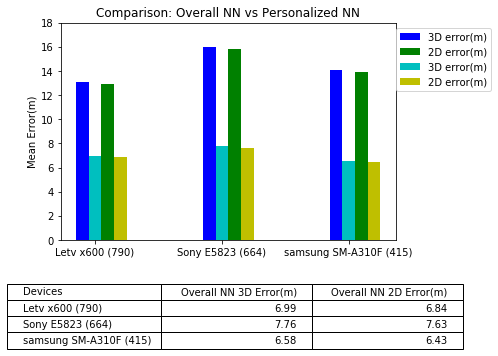

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar([-0.1,0.9,1.9], mean3d,width=0.1,color='b',label='3D error(m)',align='center')
ax.bar([0.1,1.1,2.1],mean2d, width=0.1,color='g',label='2D error(m)',align='center')

ax.bar([0.0,1.0,2.0], mean3doverall,width=0.1,color='c',label='3D error(m)',align='center')
ax.bar([0.2,1.2,2.2],mean2doverall, width=0.1,color='y',label='2D error(m)',align='center')
ax.set_title('Comparison: Overall NN vs Personalized NN');

ax.set_ylabel('Mean Error(m)');
plt.xticks(range(0,3),[d.index[0]+' ('+str(d[0])+')',d.index[1]+' ('+str(d[1])+')',d.index[2]+' ('+str(d[2])+')'])
row_labels=['Devices',d.index[0]+' ('+str(d[0])+')',d.index[1]+' ('+str(d[1])+')',d.index[2]+' ('+str(d[2])+')']
table_vals=[['Overall NN 3D Error(m)','Overall NN 2D Error(m)'],
            [float('{0:.2f}'.format(mean3doverall[0])),float('{0:.2f}'.format(mean2doverall[0]))],
            [float('{0:.2f}'.format(mean3doverall[1])),float('{0:.2f}'.format(mean2doverall[1]))],
            [float('{0:.2f}'.format(mean3doverall[2])),float('{0:.2f}'.format(mean2doverall[2]))]]
the_table = plt.table(cellText=table_vals,
                  rowLabels=row_labels,colWidths=[0.2]*2,
                  loc='right',bbox=[0.3, -0.5, 0.9, 0.3])
plt.text(80,4.0,'',size=100)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10) 
ax.set_ylim([0,18])
plt.legend(bbox_to_anchor=(1.3,1))
plt.draw()
fig.savefig('devco.eps', bbox_inches='tight')

<a id="9"></a>
### 9. Cumulative Distribution Functions of 3D localization error: net distribution and each device distribution
Diagram shows the positioning accuracy for the test cases of each devices using the overall NN. State of the art[1]  shows that less than 60% of the test points give error within 10m, whereas in our proposed method as shown below almost 90% of the test cases have positioning errors within 10m.


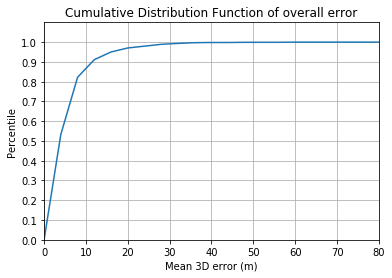

In [11]:

f=pow((np.sum(pow(abs(test_target-mlp.predict(test_data_scale)).drop(['993'],axis=1),2),axis=1)),0.5)
x = [i*4 for i in range(0,26)]
ff=np.zeros(26)
for i in range(0,25):
     ff[i+1]=sum(j<(i+1)*4 for j in f)/len(f)
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 100, 10))
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.plot(x, ff)
plt.axis([0,80,0,1.1])
ax.set_title('Cumulative Distribution Function of overall error');
ax.set_xlabel('Mean 3D error (m)');
ax.set_ylabel('Percentile');
plt.grid()
plt.show()
fig.savefig('cdftotal.eps', bbox_inches='tight')

### CDF of 3D positioning error of each device

It can be seen in the graph below that **almost all devices among these 21 cellphones generated similar mean error distribution**. Therefore, **device heterogeneity has a little impact on the proposed model**.

(1083, 992)
Letv x600
(170, 992)
(145, 992)
(78, 992)
(74, 992)
(82, 992)
(62, 992)
(58, 992)
(56, 992)
(36, 992)
(31, 992)
(36, 992)
(36, 992)
(25, 992)
(96, 992)
(81, 992)
(8, 992)
(3, 992)
(2, 992)
(2, 992)
(1, 992)
(1, 992)


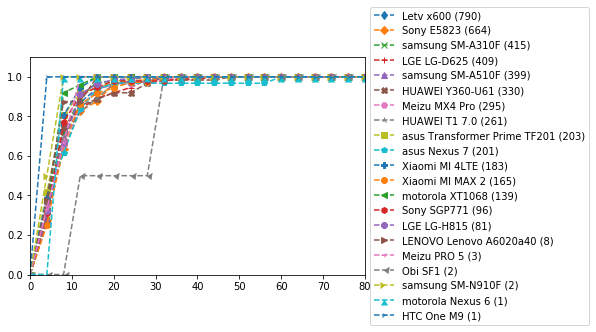

In [12]:
ff = np.zeros((21,26))
mean_err=np.zeros(21)
max_err=np.zeros(21)
d = big_data_org['995'].value_counts()
print(test_data_scale.shape)
print(d.index[0])
for k in range(0,21):
    test = np.zeros((0,992))
    test_x=np.zeros((0,3))
    train=train_data_scale.copy(deep=True)
    train_x=train_target.copy(deep=True)

    for i in range(0,test_data_scale.shape[0]):
        if big_data_org.iloc[test_data_scale.index[i]]['995']==d.index[k]:
            test=np.append(test,np.transpose(test_data_scale.loc[test_data_scale.index[i],:].values.reshape(992,1)),axis=0)
            test_x=np.append(test_x,np.transpose(test_target.loc[test_target.index[i],:].values.reshape(3,1)),axis=0)
        
    print(test.shape)
    f=pow((np.sum(pow(abs(test_x-mlp.predict(test)),2),axis=1)),0.5)
    mean_err[k]=sum(f)/len(f)
    max_err[k] =max(f)
    for i in range(0,25):
         ff[k][i+1]=sum(j<(i+1)*4 for j in f)/len(f) 
    
x = [i*4 for i in range(0,26)]
mark = ["d","D","x","+","^","X","H","2","s","p","P","o","<","h","8",">","3",4,5,6, "4"]
c=0
for a in mark:
    plt.plot(x, ff[c],linestyle='--', marker=a, label = d.index[c]+' ('+str(d[c])+')')
    c=c+1
plt.axis([0,80,0,1.1])
ax.set_title('Cumulative Distribution Function of separate device error');
ax.set_xlabel('Mean 3D error (m)');
ax.set_ylabel('Percentile');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

[1] Peng Z, Richter P, Leppkoski H, Lohan E-S. ”Analysis of Crowdsensed WiFi Fingerprints for Indoor Localization.” in Proceedings of the 21st Conference of Open Innovations Association FRUCT. Helsinki, Finland: FRUCT. 2017. p. 268-277.